In [2]:
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import h5py

import agama

import utilities as ut
import gizmo_analysis as gizmo


%matplotlib inline

# Set unit of Agama to (mass, length, velocity) = (1 Msun, 1 kpc, 1 km/s)
agama.setUnits(mass=1, length=1, velocity=1)

plt.style.use('seaborn-colorblind')
mpl.rcParams.update({
    'font.size': 18,
    'figure.figsize': (8, 6),
    'figure.facecolor': 'w',
    'axes.linewidth': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

In [3]:
# Read in DM potential and bar potential
pxr_DM = agama.Potential(file=
                         "/ocean/projects/phy210068p/hsu1/Fire_simulation/m12f_res7100/600.dark.axi_4.coef_mul_DR")
pxr_bar = agama.Potential(file=
                          "/ocean/projects/phy210068p/hsu1/Fire_simulation/m12f_res7100/600.bar.axi_4.coef_cylsp_DR")

# Combine bar and DM potential
potential = agama.Potential(pxr_DM, pxr_bar)

In [4]:
# csv = pd.read_csv('/ocean/projects/phy210068p/hsu1/data/Ananke/stars_accretion_history_m12i_res7100_v2.csv')
# acc_id = csv.id_stars
# with h5py.File(path, 'r') as f:
#     ananke_id = f['parentid'][:]
# accretion_id = np.isin(ananke_id, acc_id)
# acc_mask = (accretion_id==1)

In [15]:
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/AnankeDR3_data_reduced_m12f_lsr1.hdf5'
with h5py.File(path, 'r') as f:
    ra = f['ra'][:]
    dec = f['dec'][:]
    parallax = f['parallax'][:]
    pmra = f['pmra'][:]
    pmdec = f['pmdec'][:]
    rv = f['radial_velocity'][:]

In [16]:
# ra = ra[acc_mask]
# dec = dec[acc_mask]
# parallax = parallax[acc_mask]
# pmra = pmra[acc_mask]
# pmdec = pmdec[acc_mask]
# rv = rv[acc_mask]

In [17]:
np.shape(ra)

(133307831,)

In [18]:
# Create new data to store nan values
store_rv = rv

In [19]:
null_mask = (np.isnan(rv))
non_null_mask = (~np.isnan(rv))
rv = rv[non_null_mask]
ra = ra[non_null_mask]
dec = dec[non_null_mask]
parallax = parallax[non_null_mask]
pmra = pmra[non_null_mask]
pmdec = pmdec[non_null_mask]

In [20]:
ra = ra * u.deg
dec = dec * u.deg
parallax = parallax * u.mas
rv = rv * u.km / u.s
pmra = pmra * u.mas / u.yr
pmdec = pmdec * u.mas / u.yr

dist = coord.Distance(parallax=parallax, allow_negative=True)

# Coord transformation
icrs = coord.ICRS(
    ra=ra, dec=dec, distance=dist, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=rv)
gal = icrs.transform_to(coord.Galactocentric())

In [21]:
# Integrate and plot the orbit for 10 Billion years
posvel_accreted = np.stack([
    gal.x.to_value(u.kpc), 
    gal.y.to_value(u.kpc),
    gal.z.to_value(u.kpc),
    gal.v_x.to_value(u.km/u.s),
    gal.v_y.to_value(u.km/u.s),
    gal.v_z.to_value(u.km/u.s),   
], 1)

In [22]:
# Create an action finder from the potential to calculate the action
action_finder = agama.ActionFinder(potential)

In [23]:
Jr, Jz, Jphi = action_finder(posvel_accreted).T

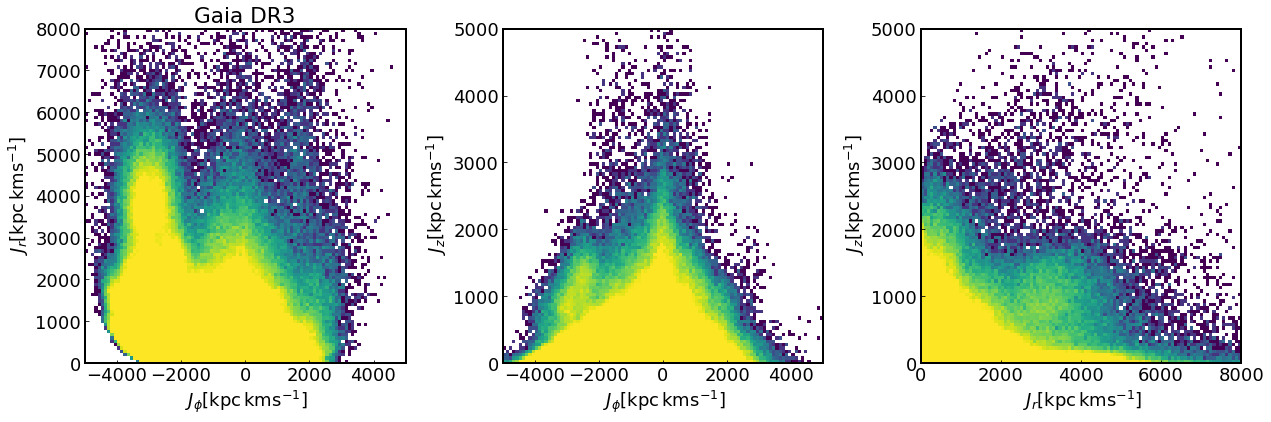

In [24]:
def plot_action(Jr, Jz, Jphi, hist_range, bins=100, norm=None):
    ''' Plot the 2d distribution of the actions'''
    
    if norm is None:
        norm = mpl.colors.LogNorm(vmin=1, vmax=100)    
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].hist2d(
        Jphi, Jr, bins=(bins, bins), range=(hist_range[2], hist_range[0]), norm=norm)
    axes[1].hist2d(
        Jphi, Jz, bins=(bins, bins), range=(hist_range[2], hist_range[1]), norm=norm)
    axes[2].hist2d(
        Jr, Jz, bins=(bins, bins), range=(hist_range[0], hist_range[1]), norm=norm)

    axes[0].set_xlabel(r' $J_\phi [\mathrm{kpc} \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[1].set_xlabel(r' $J_\phi [\mathrm{kpc} \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[2].set_xlabel(r' $J_r [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[0].set_ylabel(r' $J_r [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[1].set_ylabel(r' $J_z [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[2].set_ylabel(r' $J_z [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    fig.tight_layout()
    axes[0].set_title('Gaia DR3')
    #fig.colorbar(axes[2])
    
    return fig, axes

hist_range = ((0, 8000), (0, 5000), (-5000, 5000))
bins = 100
norm = mpl.colors.LogNorm(vmin=1, vmax=100)
fig, axes = plot_action(Jr, Jz, Jphi, hist_range, bins, norm)

In [25]:
new_Jr = np.empty(len(store_rv))
new_Jr[:] = np.nan
new_Jz = np.empty(len(store_rv))
new_Jz[:] = np.nan
new_Jphi = np.empty(len(store_rv))
new_Jphi[:] = np.nan

new_Jr[non_null_mask] = Jr
new_Jz[non_null_mask] = Jz
new_Jphi[non_null_mask] = Jphi

In [26]:
len(new_Jr) - np.sum(np.isnan(new_Jr)), np.sum(np.isnan(store_rv))

(31374396, 101933425)

In [27]:
np.sum(np.isnan(new_Jr)==np.isnan(store_rv)), len(store_rv)

(133307821, 133307831)

In [28]:
with h5py.File(path, 'a') as f:
#     del f['Jr']
#     del f['Jz']
#     del f['Jphi']
    f.create_dataset('Jr', data=new_Jr)
    f.create_dataset('Jz', data=new_Jz)
    f.create_dataset('Jphi', data=new_Jphi)

In [29]:
# path_action = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training'
# with h5py.File(path_action, 'w') as f: 
#         f.create_dataset('Jr', data=Jr)
#         f.create_dataset('Jz', data=Jz)
#         f.create_dataset('Jphi', data=Jphi)

In [30]:
f = h5py.File(path, 'r')
f.keys()

<KeysViewHDF5 ['Jphi', 'Jr', 'Jz', 'b', 'dec', 'feh', 'is_accreted', 'l', 'parallax', 'parentid', 'pmdec', 'pmra', 'ra', 'radial_velocity', 'radial_velocity_error']>

In [20]:
with h5py.File(path, 'r') as f:
    Jr_t = f['Jr'][:]

In [23]:
np.sum(np.isnan(Jr_t))

39287778